This is a place to test things and mess around.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as scop

In [122]:
trainset = pd.read_csv('train.csv', index_col = 'Id')
testset = pd.read_csv('test.csv', index_col = 'Id')

In [33]:
trainset.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [34]:
nullratio = trainset.isnull().sum() / trainset.shape[0]

In [35]:
nullratio[nullratio.values > 0]

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

Lots of missing records. Some features like Alley has a lot of NaN that indicates no alley access so the NaNs are not missing information. NaNs like those will be filled with appropriate values in digitizing the features. There are a few features with real missing information, like LotFrontage or Eletrical. Those NaN needs to be filled or those features can't be used. 

A lot of features consists of discrete data type, like MSSubClass, where the values may needs to be remapped to improve the model. Those features needs to be analyzed and possibly mapped into different features to be used in the model.

Below I examine each feature and process them to be ready for modeling.

In [98]:
aggvals = {'mean', 'std', 'count'}
a = trainset.groupby('MSSubClass').SalePrice.agg(aggvals).sort_values(by = 'mean')
a

,std,count,mean
MSSubClass,,,
30,24857.110069,69,95829
180,29474.282570,10,102300
45,20231.723876,12,108591
190,35439.097661,30,129613
90,27833.249182,52,133541
160,34587.542266,63,138647
50,54851.983702,144,143302
85,19629.942206,20,147810
40,75747.799744,4,156125


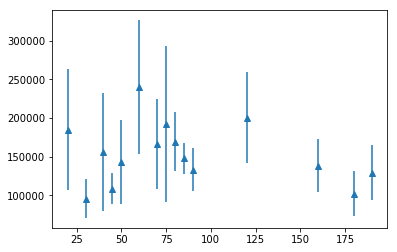

In [37]:
plt.errorbar(a.index, a['mean'], a['std'], linestyle = 'None', marker = '^')
plt.show()

Certain dwelling types have a very well defined narrow band while a few, like class 75: 2-1/2 story all ages have a relatively wide range of prices.

In [38]:
a = trainset.groupby('MSZoning').SalePrice.agg(aggvals)
a

,std,count,mean
MSZoning,,,
C (all),33791.092021,10,74528
FV,52369.662067,65,214014
RH,35714.118427,16,131558
RL,80766.341319,1151,191004
RM,48521.689830,218,126316


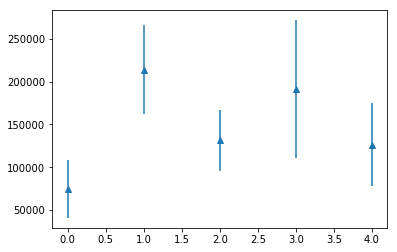

In [39]:
plt.errorbar(range(0, a.shape[0]), a['mean'], a['std'], linestyle = 'None', marker = '^')
plt.show()

Most of the records are in RL: residential low density. The few that are in other categories like Commercial have a relatively narrow range of distribution. It suggests that the feature on its own is not going to be useful in separating most of the houses apart. However, it can be useful when combined with other features.

In [49]:
uzone = trainset.MSZoning.unique()
uzonemap = dict(zip(uzone, range(0, uzone.size)))

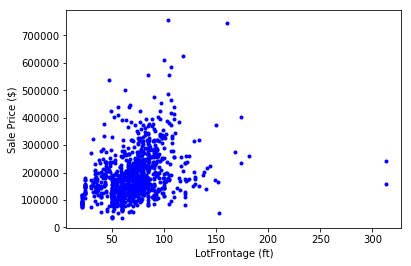

In [43]:
plt.plot(trainset.LotFrontage, trainset.SalePrice, '.b')
plt.xlabel('LotFrontage (ft)')
plt.ylabel('Sale Price ($)')
plt.show()

In [42]:
trainset[['LotFrontage', 'SalePrice']].corr()

,LotFrontage,SalePrice
LotFrontage,1.000000,0.351799
SalePrice,0.351799,1.000000


The linear feet of street connected to property has a decent correlation coefficient with the sales price. About 18% of the data in the training set is missing this information. The plot above suggests there might be at least two sub trends, one with sale price increasing much faster with LotFrontage and the other with a gentler slope between the two. This observation suggests that combining features could improve correlation to sales price. In this case, if we can find a feature that normalized the two trends and collapses them into one the correlation between the normalized LotFrontage and sales price can be greatly improved. So far it seems the subclass or the zoning are not the normalizing factor.

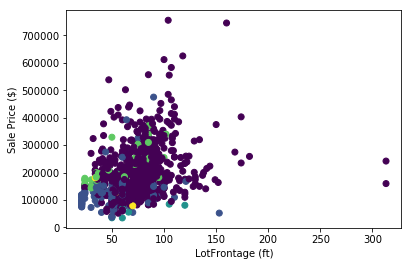

In [51]:
plt.scatter(trainset.LotFrontage, trainset.SalePrice, c = trainset.MSZoning.map(uzonemap))
plt.xlabel('LotFrontage (ft)')
plt.ylabel('Sale Price ($)')
plt.show()

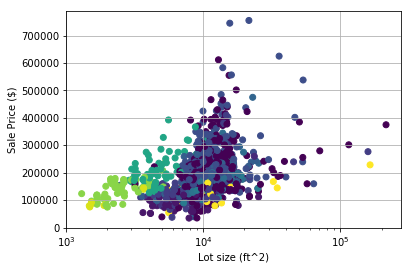

In [94]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.SalePrice, c = trainset.MSSubClass)
ax.set_xscale('log')
plt.xlabel('Lot size (ft^2)')
plt.ylabel('Sale Price ($)')
plt.grid()
plt.show()

In [129]:
trainset[['LotArea', 'SalePrice']].corr()

,LotArea,SalePrice
LotArea,1.000000,0.263843
SalePrice,0.263843,1.000000


The lot size has a wide range in the database, therefore it is more appropriate to use its logarithmic value to correlate to the sales price. The figure above shows that depending on the type of dwelling (MSSubClass), the price has different trends with $log(LotSize)$.

With the few features we examined it seems the discrete features can be used to classifity different trends the continuous features has with sales price.

In [70]:
trainset.groupby('Street').SalePrice.agg(aggvals)

,std,count,mean
Street,,,
Grvl,65446.253988,6,130190
Pave,79446.597315,1454,181130


Paved roas access seems to boost the housing price compared to gravel access. However, the sample size for the gravel access houses is very small (6). It is entirely possible the difference is biased and not appropriate to be generalized. The table belows shows those 6 records. It seems though they do represent the average house well up to the LotArea feature. We will keep this feature in mind but for now it is likely we are going to leave it out.

In [72]:
trainset[trainset.Street == 'Grvl']

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
53,90,RM,110.0,8472,Grvl,NaN,IR2,Bnk,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,110000
336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,Corner,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
583,90,RL,81.0,11841,Grvl,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,118500
813,20,C (all),66.0,8712,Grvl,NaN,Reg,Bnk,AllPub,Inside,...,0,NaN,NaN,Shed,54,6,2010,WD,Alloca,55993
1062,30,C (all),120.0,18000,Grvl,NaN,Reg,Low,AllPub,Inside,...,0,NaN,NaN,Shed,560,8,2008,ConLD,Normal,81000
1185,20,RL,50.0,35133,Grvl,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,186700


In [76]:
ualley = trainset.Alley.unique()
alleymap = dict(zip(ualley, range(-1, ualley.size-1)))
trainset.groupby(trainset.Alley.map(alleymap)).SalePrice.agg(aggvals)

,std,count,mean
Alley,,,
-1,80667.145177,1369,183452
0,34780.780727,50,122219
1,38370.375239,41,168000


The NAs in alley access type means no access so we map the NaNs into -1 to obtain statistics. Houses with alley access takes a small fraction of the total training set. 

In [87]:
(testset.isnull().sum() / testset.shape[0]).Alley

0.92666209732693627

And so is the case in the test set. As a result, we ignore the Alley feature for now. We may revisit it later for fine tuning the model for houses with alley access. Below we start a record for features we want to use, separated into discrete and continous feature sets.

In [137]:
feats_disc = ['MSSubClass', 'MSZoning']
feats_cont = ['LotFrontage', 'LotArea']

In [89]:
trainset.groupby('LotShape').SalePrice.agg(aggvals)

,std,count,mean
LotShape,,,
IR1,85858.489557,484,206101
IR2,99669.427359,41,239833
IR3,82540.334855,10,216036
Reg,69673.427209,925,164754


Lot shape is an interesting feature. It is not clear what regular means but it seems irregular lots usually fetches higher prices. The IR2 and IR3 both has small sample sizes.

In [95]:
trainset.groupby(['LotShape', 'MSSubClass']).LotShape.agg('count')

LotShape  MSSubClass
IR1       20            201
          30             11
          45              1
          50             27
          60            143
          70             13
          75              2
          80             29
          85             10
          90             10
          120            30
          160             4
          190             3
IR2       20             14
          50              3
          60             19
          75              1
          90              1
          120             2
          160             1
IR3       20              4
          30              1
          60              5
Reg       20            317
          30             57
          40              4
          45             11
          50            114
          60            132
          70             47
          75             13
          80             29
          85             10
          90             41
          120            55

In [101]:
ulots = trainset.LotShape.unique()
lotshapemap = dict(zip(ulots, range(0, ulots.size)))
trainset.groupby('LotShape').LotArea.agg(aggvals)

,std,count,mean
LotShape,,,
IR1,9279.619227,484,11894.545455
IR2,29138.010090,41,23733.658537
IR3,63129.108967,10,41338.200000
Reg,3873.766772,925,8876.915676


It seems that the reason could be irregular lots usually have larger lot area, which generally corresponds to higher prices. The irregular houses also has a higher proportion of high-price types of dwelling (MSSubClass) like type 60: 2-STORY 1946 & NEWER. It seems that the LotShape feature could be represented by other features already in the feature set. The figure below also shows it is not a good classifier for potentially different trends between other continous features. Therefore we ignore this feature for now. If we ever want to use this feature we may need to combine some categories like all IRs together since the sample size of IR2 and IR3 are relatively small.

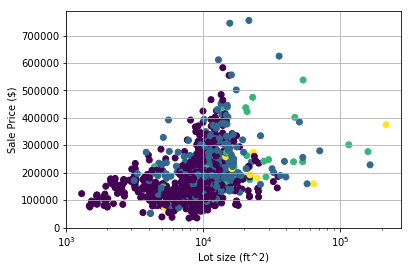

In [104]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.SalePrice, c = trainset.LotShape.map(lotshapemap))
ax.set_xscale('log')
plt.xlabel('Lot size (ft^2)')
plt.ylabel('Sale Price ($)')
plt.grid()
plt.show()

In [143]:
def generatemap(col):
    uvals = col.unique()
    return dict(zip(uvals, range(1, uvals.size + 1)))

In [130]:
landcontmap = generatemap(trainset.LandContour)
trainset.groupby('LandContour').SalePrice.agg(aggvals)

,std,count,mean
LandContour,,,
Bnk,49361.244069,63,143104
HLS,101790.139739,50,231533
Low,83935.353618,36,203661
Lvl,78463.567915,1311,180183


Similar to Alley access feature, the land contour has a small number of outliers that are not near flat with the majority of the houses with near flat countours and the mean sales price close to mean sales price for all houses. 

In [134]:
trainset.groupby('LandContour').LotArea.agg(aggvals)

,std,count,mean
LandContour,,,
Bnk,11620.246512,63,11836.888889
HLS,23032.507896,50,15264.640000
Low,44323.418020,36,33075.250000
Lvl,4069.307189,1311,9652.863463


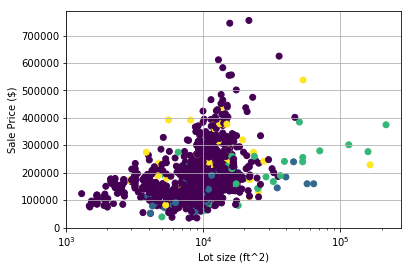

In [133]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.SalePrice, c = trainset.LandContour.map(landcontmap))
ax.set_xscale('log')
plt.xlabel('Lot size (ft^2)')
plt.ylabel('Sale Price ($)')
plt.grid()
plt.show()

It does seem the LandContour can be used as a classifier for different lot size vs. sales price relationship. Furthermore, it doesn't seem that the price for a certtain contour type is not necessarily because of its correlation to the lot size or other features we examined so far. As a result, we add it to the discrete feature list.

In [138]:
feats_disc.append('LandContour')

['MSSubClass', 'MSZoning', 'LandContour']

In [139]:
trainset.groupby('Utilities').SalePrice.agg(aggvals)

,std,count,mean
Utilities,,,
AllPub,79461.599814,1459,180950
NoSeWa,NaN,1,137500


Since all the data entries except for one in the training set has AllPub utility type, this feature is not useful in predicting house price with the current training set. We leave it out of future models.

In [149]:
trainset.groupby('LotConfig')[['SalePrice', 'LotArea']].agg(aggvals)

SalePrice                     LotArea                    
                    std count    mean           std count          mean
LotConfig                                                              
Corner     84466.041218   263  181623  11020.980129   263  11426.231939
CulDSac    93117.546585    94  223854  20157.350917    94  17342.053191
FR2        62788.926826    47  177934   4970.987226    47  10398.276596
FR3        78379.222374     4  208475   5656.072401     4   8706.250000
Inside     76426.805782  1052  176938   8113.388256  1052   9691.799430

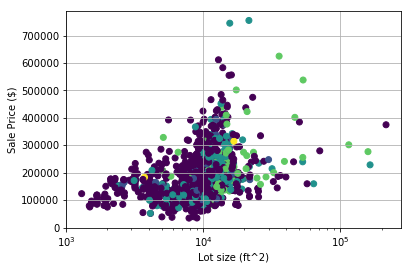

In [146]:
lotconfigmap = generatemap(trainset.LotConfig)
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.SalePrice, c = trainset.LotConfig.map(lotconfigmap))
ax.set_xscale('log')
plt.xlabel('Lot size (ft^2)')
plt.ylabel('Sale Price ($)')
plt.grid()
plt.show()

In [152]:
np.corrcoef(trainset.SalePrice, trainset.LotConfig.map(lotconfigmap))

array([[ 1.        ,  0.10910587],
       [ 0.10910587,  1.        ]])

In [154]:
trainset.groupby(['LotConfig', 'MSSubClass']).LotConfig.agg('count')

LotConfig  MSSubClass
Corner     20             99
           30             13
           40              1
           45              3
           50             31
           60             58
           70             12
           75              5
           80             11
           85              4
           90             10
           120             5
           160             5
           190             6
CulDSac    20             40
           50              4
           60             32
           80              6
           85              5
           90              1
           120             5
           160             1
FR2        20             18
           30              1
           50              3
           60             10
           80              5
           90              2
           120             4
           160             4
FR3        20              1
           70              1
           120             1
           160       

It seems that sales price can be correlated to the LotConfig feature. Furthermore, the correlation can't seem to be explained by other features we already explored. So it is added to the discete feature set.

In [155]:
feats_disc.append('LotConfig')

In [156]:
trainset.groupby('LandSlope')[['SalePrice', 'LotArea']].agg(aggvals)

SalePrice                     LotArea                    
                    std count    mean           std count          mean
LandSlope                                                              
Gtl        78669.369147  1382  179956   4639.070058  1382   9780.305355
Mod        92375.358116    65  196734  13207.937689    65  14799.415385
Sev        86729.922409    13  204379  70981.147546    13  67401.923077

In [158]:
trainset.groupby(['LandSlope', 'LandContour']).SalePrice.agg('count')

LandSlope  LandContour
Gtl        Bnk              47
           HLS              32
           Low               9
           Lvl            1294
Mod        Bnk              15
           HLS              16
           Low              18
           Lvl              16
Sev        Bnk               1
           HLS               2
           Low               9
           Lvl               1
Name: SalePrice, dtype: int64

The LandSlope feature is not the same as LandContour feature. It seems steeper slope is correlated to higher sale prices. But it could be because steeper slopes are correlated to larger lot size. The plot below shows that those with steeper slops have a larger average lot size. Those with sever slope seems to form a distinct lot size vs. sale price trend. But the feature LandContour was able to performce similarly. Therefore we leave LandSlope out for now and may revisit it later.

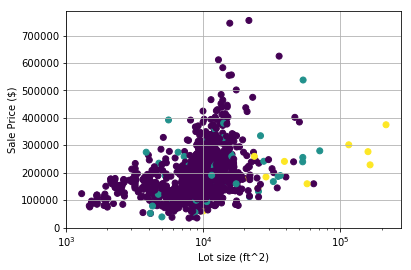

In [159]:
landslopemap = generatemap(trainset.LandSlope)
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.SalePrice, c = trainset.LandSlope.map(landslopemap))
ax.set_xscale('log')
plt.xlabel('Lot size (ft^2)')
plt.ylabel('Sale Price ($)')
plt.grid()
plt.show()

In [163]:
trainset.groupby('Neighborhood')['SalePrice'].agg(aggvals).sort_values(by = 'mean')

,std,count,mean
Neighborhood,,,
MeadowV,23491.049593,17,98576
IDOTRR,33376.710113,37,100123
BrDale,14330.176482,16,104493
BrkSide,40348.689260,58,124834
Edwards,43208.616456,100,128219
OldTown,52650.583178,113,128225
Sawyer,22345.129156,74,136793
Blueste,19091.883092,2,137500
SWISU,32622.917665,25,142591


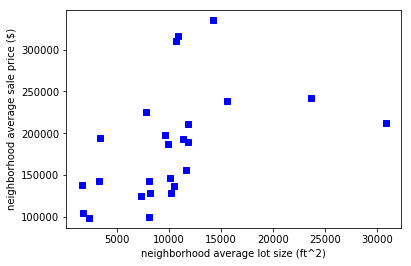

In [168]:
plt.plot(trainset.groupby('Neighborhood').LotArea.agg('mean'), trainset.groupby('Neighborhood').SalePrice.agg('mean'), 'sb')
plt.ylabel('neighborhood average sale price ($)')
plt.xlabel('neighborhood average lot size (ft^2)')
plt.show()

In [170]:
neighbormap = generatemap(trainset.Neighborhood)
np.corrcoef(trainset.SalePrice, trainset.Neighborhood.map(neighbormap))

array([[ 1.        , -0.14362115],
       [-0.14362115,  1.        ]])

As expected, neighborhood can determine the house price. It may be loosely related to lot area but clearly given a similar lot size the neighborhood can be an important factor in determining the sale price. As a result, we add it to the discrete feature list.

In [171]:
feats_disc.append('Neighborhood')

In [172]:
trainset.groupby('Condition1').SalePrice.agg(aggvals)

,std,count,mean
Condition1,,,
Artery,66226.660545,48,135091
Feedr,42157.290105,81,142475
Norm,81256.980119,1260,184495
PosA,52348.932310,8,225875
PosN,65256.536607,19,215184
RRAe,24030.813553,11,138400
RRAn,66177.922066,26,184396
RRNe,5303.300859,2,190750
RRNn,93823.238060,5,212400


It seems that near or adjacent to positive features promotes the sale price while adjacent to street, either artery or feeder, reduces sale price.

In [173]:
trainset.groupby('Condition1').LotArea.agg(aggvals)

,std,count,mean
Condition1,,,
Artery,4686.631946,48,10001.333333
Feedr,8306.278047,81,10729.604938
Norm,10410.488749,1260,10417.626984
PosA,5481.137108,8,16612.375000
PosN,7388.352049,19,12732.842105
RRAe,3365.637681,11,11713.727273
RRAn,4587.704110,26,11982.500000
RRNe,114.551299,2,9372.000000
RRNn,2058.391605,5,9046.800000


It seems the difference is not likely due to lot sizes as shown in the table above. Most conditions have a very similar average lot size. With a few exceptions, mostly in those with positive features. House adjacent to E-W railraod has a much lower average sale price than those adjacent to the N-S railroad. The table below shows the reason could be those adjacent to N-S railroad are mostly 2-STORY 1946 & NEWER, the type with the highest average sale price. This feature may be influenced by MSSubClass a little bit but it contains valuable independent information, like positive features, to be considered in predictive models.

In [176]:
trainset.groupby(['Condition1', 'MSSubClass']).SalePrice.agg('count')

Condition1  MSSubClass
Artery      20              4
            30              5
            45              1
            50             21
            60              1
            70              6
            75              3
            80              1
            90              3
            190             3
Feedr       20             32
            30              6
            45              1
            50             13
            60              8
            70              4
            80              3
            85              1
            90             10
            190             3
Norm        20            473
            30             57
            40              3
            45              9
            50            108
            60            262
            70             46
            75             12
            80             53
            85             18
            90             36
            120            87
            160  

In [178]:
trainset.groupby(['Condition1', 'Condition2']).SalePrice.agg(aggvals)

std  count    mean
Condition1 Condition2                              
Artery     Artery       16263.455967      2  106500
           Norm         61751.796032     45  132142
           PosA                  NaN      1  325000
Feedr      Feedr                 NaN      1   85000
           Norm         41738.486850     76  143883
           RRAe                  NaN      1  190000
           RRAn                  NaN      1  136905
           RRNn         39951.533137      2   96750
Norm       Norm         81256.980125   1260  184495
PosA       Norm         52348.932313      8  225875
PosN       Norm         53470.236361     17  206985
           PosN        141598.132933      2  284875
RRAe       Norm         24030.813553     11  138400
RRAn       Feedr        36771.818920      4  128500
           Norm         65705.473386     22  194559
RRNe       Norm          5303.300859      2  190750
RRNn       Feedr                 NaN      1  128000
           Norm         93642.938869      4  233500

The table above confirms that some conditions are negative ones (Artery, Feedr, RRAe, RRAn) that reduces sale price, and others are positive features. We would like to use the conditions in predictive models. One way to map them into numerical values is to map Norm to 0, the negative ones as negative numbers depending on their mean sale price difference from the Norm ones, and the positive ones as positive numbers.

In [185]:
a = trainset.groupby('Condition1').SalePrice.agg('mean')
a = a - a.loc['Norm']
condmap = a / (np.abs(a)).max()
condmap

Condition1
Artery   -1.000000
Feedr    -0.850538
Norm      0.000000
PosA      0.837584
PosN      0.621185
RRAe     -0.933022
RRAn     -0.002004
RRNe      0.126609
RRNn      0.564833
Name: SalePrice, dtype: float64

In [187]:
feats_disc.append(['Condition1', 'Condition2'])

In [191]:
trainset.groupby('BldgType')[['SalePrice', 'LotArea', 'LotFrontage']].agg(aggvals)

SalePrice                     LotArea                      \
                   std count    mean           std count          mean   
BldgType                                                                 
1Fam      82648.502921  1220  185763   9578.993997  1220  11240.634426   
2fmCon    35458.545148    31  128432  28406.567955    31  15785.064516   
Duplex    27833.249182    52  133541   3146.827768    52   9720.057692   
Twnhs     41013.222075    43  135911    996.746708    43   2391.209302   
TwnhsE    60626.108914   114  181959   2315.905870   114   4766.605263   

         LotFrontage                   
                 std count       mean  
BldgType                               
1Fam       22.514368   994  74.503018  
2fmCon     15.166797    28  66.428571  
Duplex     14.296031    47  71.595745  
Twnhs       5.185718    40  24.675000  
TwnhsE     11.788408    92  41.978261

In [199]:
btmap = generatemap(trainset.BldgType)
btmap

{'1Fam': 1, '2fmCon': 2, 'Duplex': 3, 'Twnhs': 5, 'TwnhsE': 4}

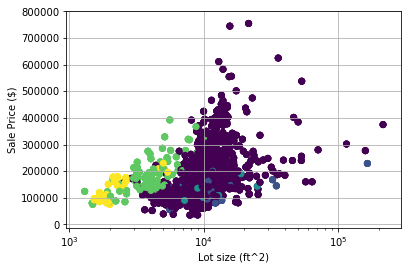

In [198]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.SalePrice, c = trainset.BldgType.map(btmap))
ax.set_xscale('log')
plt.xlabel('Lot size (ft^2)')
plt.ylabel('Sale Price ($)')
plt.grid()
plt.show()

There is a correlation between building type to sales price and it doesn't seem to be related to the continous features we investigated so far. Furthermore, this features and the house style feature helps us to recognize houses with a relative small lot size but a much larger living space size due to multiple floors/house styles. The figure above demonstrates that power. The yellow and green dots represents townhouses, houses with small lot size but larger living space so its price to lot size trend is different from the rest. However, this separation was achieved by MSSubClass feature. In fact, MSSubClass feature contains both information from BldgType and HouseStyle. Therefore we leave those two out of the to-be-modeled feature list for now.

In [193]:
trainset.groupby('HouseStyle')[['SalePrice', 'LotArea', 'LotFrontage']].agg(aggvals)

SalePrice                     LotArea                      \
                      std count    mean           std count          mean   
HouseStyle                                                                  
1.5Fin       54277.941118   154  143116  17866.666281   154  11448.623377   
1.5Unf       19036.473071    14  110150   1825.768879    14   7118.714286   
1Story       77055.715005   726  175985  10231.399025   726  10644.409091   
2.5Fin      118211.976669     8  220000   6139.341984     8  12468.125000   
2.5Unf       63934.128030    11  157354   2264.804848    11   9153.272727   
2Story       87339.213570   445  210051   6433.772688   445  10325.166292   
SFoyer       30480.898182    37  135074   3555.136425    37   7672.837838   
SLvl         38305.161336    65  166703   3431.246275    65  10537.738462   

           LotFrontage                   
                   std count       mean  
HouseStyle                               
1.5Fin       17.542142   136  63.830882  
1.5Unf        4.011202    13  54.615385  
1Story       22.538826   598  71.822742  
2.5Fin       16.756662     8  78.750000  
2.5Unf       14.109099    10  61.800000  
2Story       29.225100   362  70.350829  
SFoyer       23.061661    30  57.233333  
SLvl         19.868849    44  76.295455

In [207]:
hsmap = generatemap(trainset.HouseStyle.sort_values(inplace = False))
hsmap

{'1.5Fin': 1,
 '1.5Unf': 2,
 '1Story': 3,
 '2.5Fin': 4,
 '2.5Unf': 5,
 '2Story': 6,
 'SFoyer': 7,
 'SLvl': 8}

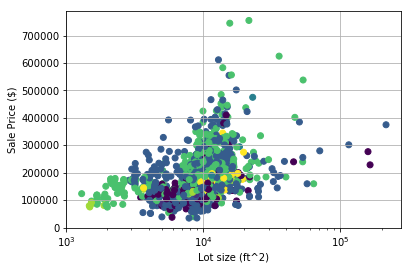

In [208]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.SalePrice, c = trainset.HouseStyle.map(hsmap))
ax.set_xscale('log')
plt.xlabel('Lot size (ft^2)')
plt.ylabel('Sale Price ($)')
plt.grid()
plt.show()

In [216]:
trainset[['OverallQual', 'SalePrice']].corr()

,OverallQual,SalePrice
OverallQual,1.000000,0.790982
SalePrice,0.790982,1.000000


In [217]:
(testset.isnull().sum() / testset.shape[0]).OverallQual

0.0

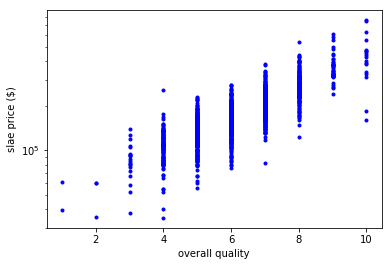

In [221]:
plt.semilogy(trainset.OverallQual, trainset.SalePrice, '.b')
plt.xlabel('overall quality')
plt.ylabel('slae price ($)')
plt.show()

The house price follows a exponential trend with the overall quality very well. The testing set has no missing overall quality information. Therefore this is a very important feature to use in models

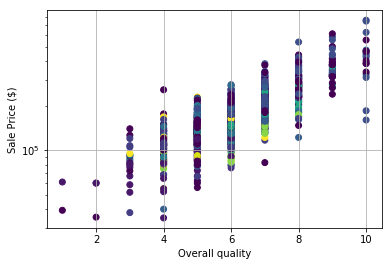

In [227]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.OverallQual, trainset.SalePrice, c = trainset.MSSubClass)
ax.set_yscale('log')
plt.xlabel('Overall quality')
plt.ylabel('Sale Price ($)')
plt.grid()
plt.show()

So far there is no consistent trends for sale price at a given quality rating. 

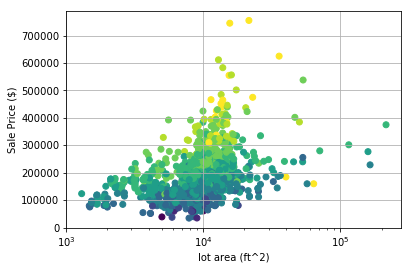

In [229]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.SalePrice, c = trainset.OverallQual)
ax.set_xscale('log')
plt.xlabel('lot area (ft^2)')
plt.ylabel('Sale Price ($)')
plt.grid()
plt.show()

However, when looked with a different perspective, it seems overall quality is very good at separating different sale price vs. lot area trends. We restrict the data set to a smaller range of lot area to look at it more closely.

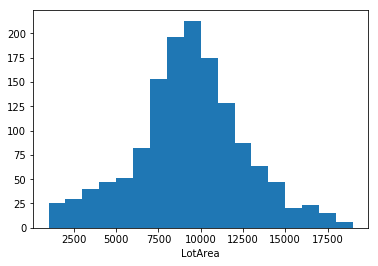

In [237]:
bins = range(1000, 20000, 1000)
plt.hist(trainset.LotArea.values, bins)
plt.xlabel('LotArea')
plt.show()

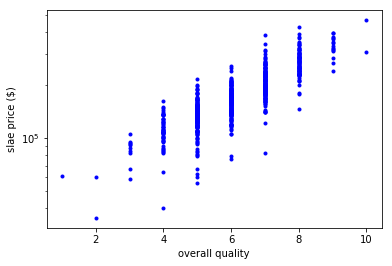

In [252]:
modarea_trainset = trainset[(trainset.LotArea > 8000) & (trainset.LotArea < 12000)]
plt.semilogy(modarea_trainset.OverallQual, modarea_trainset.SalePrice, '.b')
plt.xlabel('overall quality')
plt.ylabel('slae price ($)')
plt.show()

In [254]:
trainset.groupby('OverallQual').SalePrice.agg(aggvals)

,std,count,mean
OverallQual,,,
1,15344.217152,2,50150
2,14254.200784,3,51770
3,24688.567395,20,87473
4,29022.003876,116,108420
5,27107.330927,397,133523
6,36090.182931,374,161603
7,44466.259411,319,207716
8,63898.902252,168,274735
9,81278.174844,43,367513


In [257]:
a = trainset.groupby('OverallQual').SalePrice.agg('mean')
oqmap = a / a.loc[5]

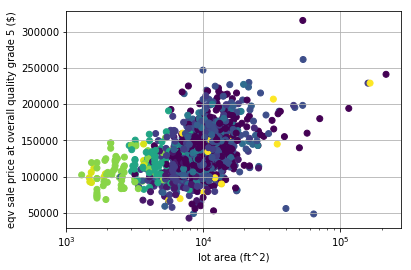

In [260]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.SalePrice / trainset.OverallQual.map(oqmap), c = trainset.MSSubClass)
ax.set_xscale('log')
plt.xlabel('lot area (ft^2)')
plt.ylabel('eqv sale price at overall quality grade 5 ($)')
plt.grid()
plt.show()

As we can see from the figure above, using overall quality to normalize the house price works very well. The trend between lot area and normalized house price is more consistent. There are still at leat two different trends, but they can be separated by the MSSubClass feature (color of the dots).

To briefly revidew, we are setting up the features to build a two tired model. First is a classification problem where we put a house into a certain (lot area, lot frontage) vs. sales price category based on discrete feature sets. Then we use linear regression to map the actual (lot area, lot frontage) to a sales price.

In [261]:
feats_disc.append('OverallQual')

In [264]:
trainset[['OverallQual', 'OverallCond', 'SalePrice']].corr()

,OverallQual,OverallCond,SalePrice
OverallQual,1.000000,-0.091932,0.790982
OverallCond,-0.091932,1.000000,-0.077856
SalePrice,0.790982,-0.077856,1.000000


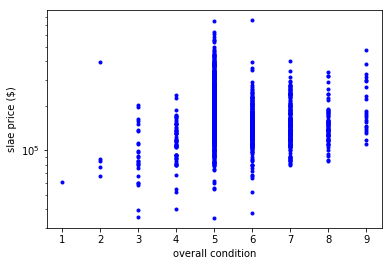

In [263]:
plt.semilogy(trainset.OverallCond, trainset.SalePrice, '.b')
plt.xlabel('overall condition')
plt.ylabel('slae price ($)')
plt.show()

Disappointingly, the overall condition doesn't correlate well to the sale price.  There is a weak relationship between the two variables but once a house gets rating of 5 or higher (most houses) the difference becomes much smaller. In particular, the range of prices shrinks for houses with condition from 5 to 9 but the average value remains more or less stable. We leave this feature out.

In [265]:
trainset[['OverallQual', 'YearBuilt', 'SalePrice']].corr()

,OverallQual,YearBuilt,SalePrice
OverallQual,1.000000,0.572323,0.790982
YearBuilt,0.572323,1.000000,0.522897
SalePrice,0.790982,0.522897,1.000000


In [266]:
trainset[['OverallQual', 'YearRemodAdd', 'SalePrice']].corr()

,OverallQual,YearRemodAdd,SalePrice
OverallQual,1.000000,0.550684,0.790982
YearRemodAdd,0.550684,1.000000,0.507101
SalePrice,0.790982,0.507101,1.000000


Both original construction date and the remodel date correlates well with the sale price. As we observed from MSSubClass, newer houses usually sells higher. 

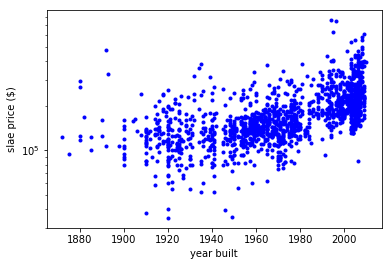

In [268]:
plt.semilogy(trainset.YearBuilt, trainset.SalePrice, '.b')
plt.xlabel('year built')
plt.ylabel('slae price ($)')
plt.show()

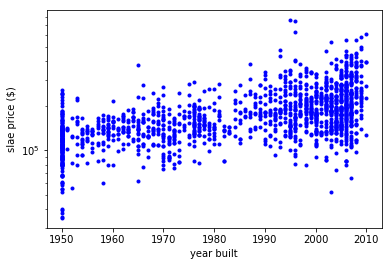

In [269]:
plt.semilogy(trainset.YearRemodAdd, trainset.SalePrice, '.b')
plt.xlabel('year built')
plt.ylabel('slae price ($)')
plt.show()

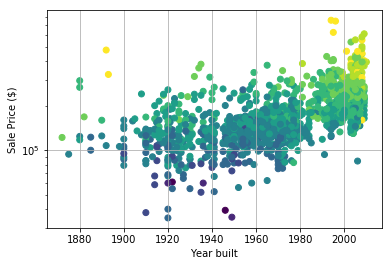

In [270]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.YearBuilt, trainset.SalePrice, c = trainset.OverallQual)
ax.set_yscale('log')
plt.xlabel('Year built')
plt.ylabel('Sale Price ($)')
plt.grid()
plt.show()

The plot above shows that new houses also generally have higher overall quality rating. That could be the driver for newer houses to be more expensive. We normalize the house price with overall quality.

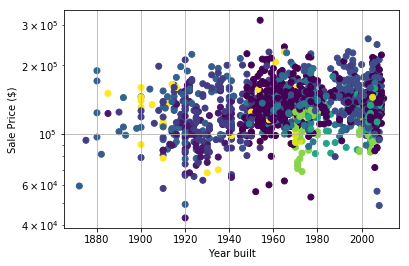

In [277]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.YearBuilt, trainset.SalePrice / trainset.OverallQual.map(oqmap), c = trainset.MSSubClass)
ax.set_yscale('log')
plt.xlabel('Year built')
plt.ylabel('Sale Price ($)')
plt.grid()
plt.show()

In [274]:
trainset = trainset.assign(NSP_overallq = trainset.SalePrice / trainset.OverallQual.map(oqmap))

In [276]:
trainset[['YearBuilt', 'NSP_overallq', 'SalePrice']].corr()

,YearBuilt,NSP_overallq,SalePrice
YearBuilt,1.000000,0.182927,0.522897
NSP_overallq,0.182927,1.000000,0.520401
SalePrice,0.522897,0.520401,1.000000


The figure and table above shows that most of the correlation between YearBuilt and SalePrice was due to the correlation between YearBuilt and OverallQual and the correlation between OverallQual and YearBuilt. After normzalization, there is still a weak trend between YearBuilt and normalized price. This difference is most obvious between houses built before around 1950 and houses built after 1950. We have already seen a similar behavior represented by the MSSubClass feature. As a result, we leave YearBuilt and YearRemodAdd out for now.

In [279]:
trainset.groupby('RoofStyle')[['SalePrice', 'NSP_overallq', 'LotArea']].agg(aggvals)

SalePrice                NSP_overallq                       \
                     std count    mean           std count           mean   
RoofStyle                                                                   
Flat        62522.963509    13  194690  58848.992088    13  161450.373454   
Gable       66331.237294  1141  171483  28564.946415  1141  132011.093479   
Gambrel     67013.527806    11  148909  47374.053661    11  130208.209551   
Hip        111549.603563   286  218876  31275.109356   286  137929.305776   
Mansard     58057.624624     7  180568  20819.891832     7  140466.372491   
Shed        49497.474683     2  225000  16170.153657     2  178565.974696   

                LotArea                      
                    std count          mean  
RoofStyle                                    
Flat       12601.624300    13  22535.846154  
Gable       8684.767009  1141   9926.604733  
Gambrel     2468.678999    11   9434.000000  
Hip        13762.306238   286  12277.860140  
Mansard      870.809968     7  11088.571429  
Shed        3326.937330     2  21242.500000

Most of the houses have a very similar normalized sale price. Some roof type seems to be correlated to higher overall quality (like Hip) thus boosting the Sale Price but not normalized SP by much. There are a few outliers categories with very different sale prices. However, the sample sizes for those categories (like flat) is very small compared to the rest of the dataset. Further more, part of the difference in normalized SP could be explained by LotArea. Therefore we can conclude most of the differences between roof type can be explained by overall quality and lot area and we can leave this feature out. For similar reasons (see table below) we can also leave RoofMatl out.

In [281]:
trainset.groupby('RoofMatl')[['SalePrice', 'NSP_overallq', 'LotArea']].agg(aggvals)

SalePrice                NSP_overallq                       \
                    std count    mean           std count           mean   
RoofMatl                                                                   
ClyTile             NaN     1  160000           NaN     1   48710.133428   
CompShg    77722.388636  1434  179803  29289.680719  1434  133231.154912   
Membran             NaN     1  241500           NaN     1  155239.868378   
Metal               NaN     1  180000           NaN     1  148723.352908   
Roll                NaN     1  137000           NaN     1  137000.000000   
Tar&Grv    65430.141720    11  185406  63860.029705    11  157914.070378   
WdShake    36218.779659     5  241400  23157.346525     5  139024.293375   
WdShngl   206969.019421     6  390250  37307.731992     6  161442.514737   

               LotArea                      
                   std count          mean  
RoofMatl                                    
ClyTile            NaN     1  63887.000000  
CompShg    9630.867776  1434  10270.289400  
Membran            NaN     1  39104.000000  
Metal              NaN     1  21453.000000  
Roll               NaN     1  11345.000000  
Tar&Grv   13006.544839    11  20732.636364  
WdShake    4921.663713     5  15797.800000  
WdShngl   24686.835461     6  30689.500000

In [282]:
trainset.groupby('Exterior1st')[['SalePrice', 'NSP_overallq', 'LotArea']].agg(aggvals)

SalePrice                NSP_overallq                       \
                       std count    mean           std count           mean   
Exterior1st                                                                   
AsbShng       33756.480660    20  107385  25116.874073    20  118910.601804   
AsphShn                NaN     1  100000           NaN     1  100000.000000   
BrkComm       15556.349186     2   71000  46081.264491     2   92584.374607   
BrkFace       82841.914370    50  194573  36411.430686    50  149422.387526   
CBlock                 NaN     1  105000           NaN     1  129311.151079   
CemntBd      120575.621318    61  231690  35749.508103    61  132440.470007   
HdBoard       66305.714164   222  163077  25091.714399   222  132898.782009   
ImStucc                NaN     1  262000           NaN     1  127333.707027   
MetalSd       54776.408990   220  149422  28012.723318   220  128542.603992   
Plywood       49497.383293   108  175942  35666.086201   108  146775.127524   
Stone         40305.086528     2  258500  35745.326460     2  164759.632647   
Stucco        83307.246529    25  162990  33424.480536    25  119182.679184   
VinylSd       80646.975785   515  213732  25627.083609   515  136046.533598   
Wd Sdng       71130.448152   206  149841  34644.599205   206  127569.607403   
WdShing       72507.530741    26  150655  26272.549369    26  122575.411867   

                  LotArea                      
                      std count          mean  
Exterior1st                                    
AsbShng       2333.257732    20   7758.800000  
AsphShn               NaN     1   9825.000000  
BrkComm        449.012806     2   9888.500000  
BrkFace      29251.108523    50  14959.100000  
CBlock                NaN     1   5400.000000  
CemntBd       8690.976153    61   9198.540984  
HdBoard       5379.483524   222  10278.243243  
ImStucc               NaN     1  12461.000000  
MetalSd       4213.934304   220   8611.622727  
Plywood      19643.624793   108  14442.722222  
Stone          977.928678     2  14806.500000  
Stucco       11740.520737    25  11621.000000  
VinylSd       3765.219401   515   9904.660194  
Wd Sdng      12184.526053   206  11721.762136  
WdShing       8666.129188    26  10423.153846

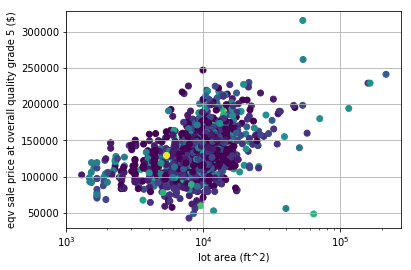

In [284]:
extmap = generatemap(trainset.Exterior1st)
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.NSP_overallq, c = trainset.Exterior1st.map(extmap))
ax.set_xscale('log')
plt.xlabel('lot area (ft^2)')
plt.ylabel('eqv sale price at overall quality grade 5 ($)')
plt.grid()
plt.show()

The plot above shows that Exterior material has very little effect on the sale price vs. lot area relationship. Besides a few outliers this feature doesn't help us distinguishing sale prices. Therefore we leave both exterior features out.

In [285]:
trainset.groupby('MasVnrType')[['SalePrice', 'NSP_overallq', 'LotArea']].agg(aggvals)

SalePrice                NSP_overallq                       \
                     std count    mean           std count           mean   
MasVnrType                                                                  
BrkCmn      46187.583624    15  146318  35504.138122    15  137574.763380   
BrkFace     81214.293551   445  204691  27507.244177   445  137402.003949   
None        60708.262790   864  156221  30459.002823   864  130654.360842   
Stone       99940.156574   128  265583  31108.209810   128  138695.094978   

                 LotArea                      
                     std count          mean  
MasVnrType                                    
BrkCmn      38672.299906    15  21865.600000  
BrkFace      5035.050149   445  10269.871910  
None        10403.753313   864  10248.175926  
Stone       11562.194082   128  11750.500000

The table above shows that the main difference between those with veneer and those without: those without has a smaller normalized sale price. This classifier is not realted to Lot area or other factors we discussed already. Therefore we simply this feature into a simple binary feature and add it to the discrete feature list. about 5% of the records does miss this feature, we treat them as having some kind of veneer for now.

In [288]:
mastypemap = {'None': 0} 
""" use fillna(1) to populate the mapped value for others """
feats_disc.append('MasVnrType')

In [289]:
trainset[['MasVnrArea', 'NSP_overallq', 'LotArea']].corr()

,MasVnrArea,NSP_overallq,LotArea
MasVnrArea,1.00000,0.165900,0.104160
NSP_overallq,0.16590,1.000000,0.351191
LotArea,0.10416,0.351191,1.000000


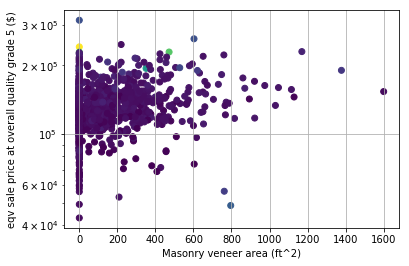

In [291]:
extmap = generatemap(trainset.Exterior1st)
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.MasVnrArea, trainset.NSP_overallq, c = trainset.LotArea)
ax.set_yscale('log')
plt.xlabel('Masonry veneer area (ft^2)')
plt.ylabel('eqv sale price at overall quality grade 5 ($)')
plt.grid()
plt.show()

The plot above suggests that veneer size may actually play a role in determining the sale price. And it is not driven by lot size. Since we found no difference between different types of veneer we drop MasVnrType and add MasVnrArea as a feature for model building.

In [293]:
feats_disc.remove('MasVnrType')
feats_cont.append('MasVnrArea')

In [294]:
feats_cont

['LotFrontage', 'LotArea', 'MasVnrArea']

In [296]:
extermap = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
np.corrcoef(trainset.ExterQual.map(extermap), trainset.NSP_overallq)

array([[ 1.        ,  0.12715258],
       [ 0.12715258,  1.        ]])

Here for exterior quality and condition features we use the same mapping that considers the grade to be ordered. 

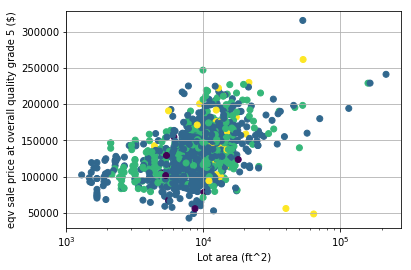

In [304]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.NSP_overallq, c = trainset.ExterQual.map(extermap))
ax.set_xscale('log')
plt.xlabel('Lot area (ft^2)')
plt.ylabel('eqv sale price at overall quality grade 5 ($)')
plt.grid()
plt.show()

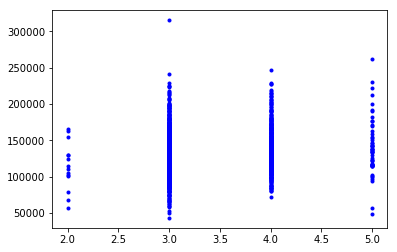

In [302]:
plt.plot(trainset.ExterQual.map(extermap), trainset.NSP_overallq, '.b')
plt.show()

In [305]:
np.corrcoef(trainset.ExterQual.map(extermap), trainset.OverallQual)

array([[ 1.        ,  0.72627849],
       [ 0.72627849,  1.        ]])

As it turns out the external quality is highly correlatable to overall quality. Since we already have overall quality in the feature set we leave ExterQual out for now.

In [306]:
np.corrcoef(trainset.ExterCond.map(extermap), trainset.NSP_overallq)

array([[ 1.        ,  0.07117498],
       [ 0.07117498,  1.        ]])

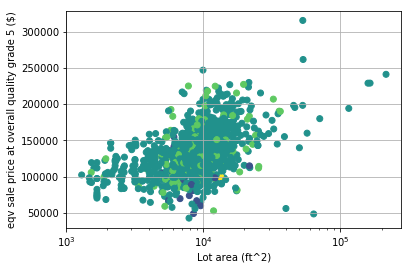

In [307]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.NSP_overallq, c = trainset.ExterCond.map(extermap))
ax.set_xscale('log')
plt.xlabel('Lot area (ft^2)')
plt.ylabel('eqv sale price at overall quality grade 5 ($)')
plt.grid()
plt.show()

The external condition, like the overall condition feature, matters very little for the normalized sale price. As a result, it is left out.

In [309]:
trainset.groupby('Foundation')[['NSP_overallq', 'LotArea']].agg(aggvals)

NSP_overallq                            LotArea        \
                     std count           mean           std count   
Foundation                                                          
BrkTil      32261.663476   146  116969.508580   4773.152522   146   
CBlock      29556.247624   634  134492.063643  13814.097039   634   
PConc       28300.771181   647  136757.214795   5585.259439   647   
Slab        28573.487962    24  121982.691002   3554.162771    24   
Stone       29233.880161     6  134258.800611   1622.667249     6   
Wood        42584.165468     3  127802.955338   1501.481602     3   

                          
                    mean  
Foundation                
BrkTil       9159.171233  
CBlock      11272.364353  
PConc       10139.599691  
Slab         9117.625000  
Stone        9014.666667  
Wood        12473.000000

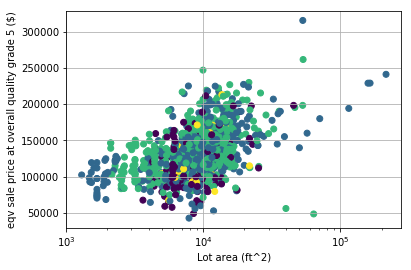

In [311]:
fdmap = {'BrkTil': 1, 'CBlock': 2, 'PConc': 3}
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.NSP_overallq, c = trainset.Foundation.map(fdmap).fillna(4))
ax.set_xscale('log')
plt.xlabel('Lot area (ft^2)')
plt.ylabel('eqv sale price at overall quality grade 5 ($)')
plt.grid()
plt.show()

Most of the houses in the training set fall into three foundation categories. And the figure above suggests the different categories may represent a different Lot Area vs. normalize sale price trend. Therefore we add this feature to the discrete feature list.

In [312]:
feats_disc.append('Foundation')

In [314]:
bsmtqmap = {'Ex': 10, 'Gd': 9, 'TA': 8, 'Fa': 7, 'Po': 4}
""" fill NaN with 0 since NA means no basement """
np.corrcoef(trainset.BsmtQual.map(bsmtqmap).fillna(0), trainset.NSP_overallq)

array([[ 1.        ,  0.13920891],
       [ 0.13920891,  1.        ]])

In [316]:
np.corrcoef(trainset.BsmtQual.map(bsmtqmap).fillna(0), trainset.OverallQual)

array([[ 1.        ,  0.47569235],
       [ 0.47569235,  1.        ]])

In [317]:
trainset.groupby('BsmtQual').NSP_overallq.agg(aggvals)

,std,count,mean
BsmtQual,,,
Ex,34527.244070,121,144344.607991
Fa,29966.949284,35,118334.909713
Gd,28307.288544,618,137070.420721
TA,29423.393764,649,129676.901812


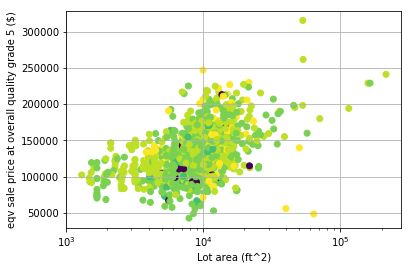

In [318]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.NSP_overallq, c = trainset.BsmtQual.map(bsmtqmap).fillna(0))
ax.set_xscale('log')
plt.xlabel('Lot area (ft^2)')
plt.ylabel('eqv sale price at overall quality grade 5 ($)')
plt.grid()
plt.show()

The Basement quality feature, like ExterQual feature, can be considered to be part of the OverallQual feature. It still has a non-trivial correlation coefficient to the normalized sale price so it could still add onto what OverallQual alone can predict. However, the figure above shows it is difficult to use this feature to distinguish different trends between lot area and normalized price. As a result, we leave this feature out for now. 

In [319]:
np.corrcoef(trainset.BsmtCond.map(extermap).fillna(0), trainset.NSP_overallq)

array([[ 1.        ,  0.10536317],
       [ 0.10536317,  1.        ]])

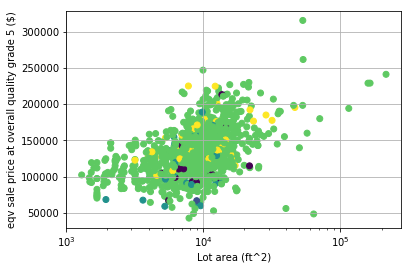

In [320]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.NSP_overallq, c = trainset.BsmtCond.map(extermap).fillna(0))
ax.set_xscale('log')
plt.xlabel('Lot area (ft^2)')
plt.ylabel('eqv sale price at overall quality grade 5 ($)')
plt.grid()
plt.show()

In [322]:
trainset.groupby('BsmtCond').NSP_overallq.agg(aggvals)

,std,count,mean
BsmtCond,,,
Fa,31760.638129,45,119597.331862
Gd,30790.545938,65,139823.694160
Po,67465.643136,2,114705.413759
TA,29584.629740,1311,134078.884674


Most of the BsmtCond is in one category and there is no clear logical correlation of the category to normalized price (or rather the differences in the table above is driven by other factors), so we leave it out for now.

In [324]:
trainset.groupby('BsmtExposure')[['NSP_overallq', 'LotArea']].agg(aggvals)

NSP_overallq                            LotArea        \
                       std count           mean           std count   
BsmtExposure                                                          
Av            29234.485667   221  135874.206653   6095.423037   221   
Gd            38790.251255   134  153215.381945  28375.152035   134   
Mn            28934.798830   114  137687.012417   4574.736167   114   
No            27504.616655   953  130218.390869   4059.067750   953   

                            
                      mean  
BsmtExposure                
Av            10483.484163  
Gd            19244.485075  
Mn            10705.219298  
No             9318.587618

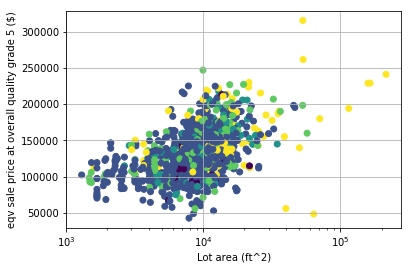

In [325]:
bsexpmap = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1}
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.NSP_overallq, c = trainset.BsmtExposure.map(bsexpmap).fillna(0))
ax.set_xscale('log')
plt.xlabel('Lot area (ft^2)')
plt.ylabel('eqv sale price at overall quality grade 5 ($)')
plt.grid()
plt.show()

The figure and table above both shows that this feature doesn't provide further predictive power so we leave it out

In [328]:
trainset.groupby('BsmtFinType1')[['NSP_overallq', 'LotArea']].agg(aggvals)

NSP_overallq                            LotArea        \
                       std count           mean           std count   
BsmtFinType1                                                          
ALQ           29670.620242   220  141708.000186  18414.755279   220   
BLQ           30697.884239   148  136141.703100   6814.453463   148   
GLQ           29480.959734   418  140278.017208   8130.112053   418   
LwQ           29447.938120    74  132073.719894   5318.270019    74   
Rec           27981.394653   133  134347.610951  13906.885489   133   
Unf           27532.308630   430  122964.227599   4249.797995   430   

                            
                      mean  
BsmtFinType1                
ALQ           11579.890909  
BLQ           10870.641892  
GLQ           10730.160287  
LwQ            9579.351351  
Rec           11631.827068  
Unf            9565.309302

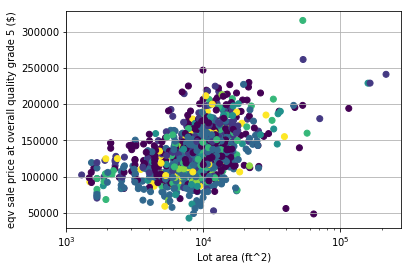

In [329]:
bsftmap = generatemap(trainset.BsmtFinType1)
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.NSP_overallq, c = trainset.BsmtFinType1.map(bsftmap).fillna(0))
ax.set_xscale('log')
plt.xlabel('Lot area (ft^2)')
plt.ylabel('eqv sale price at overall quality grade 5 ($)')
plt.grid()
plt.show()

It is difficult to see from the plot above how basement finished area rating can help with differentiating the trends. But the table above does suggest having a better basement rating helps with the normalized price. To capture this information we add this feature to our lists.

This discrete feature is different from those we examined before. The features we kept so far are going to help us classify a house into different lot area vs. normalized price trends. This feature, however, functions as an additional piece of information to fine tune the price from those trends. Therefore we create a new list for those features.

In [332]:
feats_tune = ['BsmtFinType1']

In [338]:
trainset[['BsmtFinSF1', 'NSP_overallq', 'LotArea', 'SalePrice']].corr()

,BsmtFinSF1,NSP_overallq,LotArea,SalePrice
BsmtFinSF1,1.000000,0.319333,0.214103,0.386420
NSP_overallq,0.319333,1.000000,0.351191,0.520401
LotArea,0.214103,0.351191,1.000000,0.263843
SalePrice,0.386420,0.520401,0.263843,1.000000


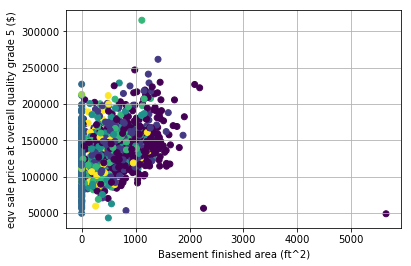

In [392]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.BsmtFinSF1, trainset.NSP_overallq, c = trainset.BsmtFinType1.map(bsftmap).fillna(0))
plt.xlabel('Basement finished area (ft^2)')
plt.ylabel('eqv sale price at overall quality grade 5 ($)')
plt.grid()
plt.show()

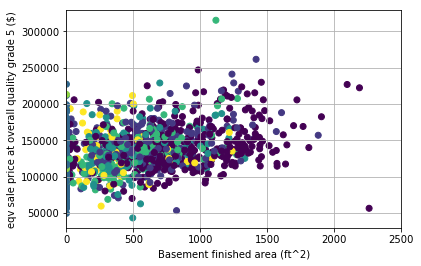

In [391]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.BsmtFinSF1, trainset.NSP_overallq, c = trainset.BsmtFinType1.map(bsftmap).fillna(0))
plt.xlabel('Basement finished area (ft^2)')
plt.ylabel('eqv sale price at overall quality grade 5 ($)')
plt.xlim([0, 2500])
plt.grid()
plt.show()

Except for a few outliers, the normalized price correlates well to the basement finished area (type 1).

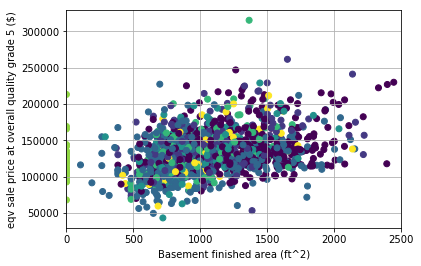

In [344]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.TotalBsmtSF, trainset.NSP_overallq, c = trainset.BsmtFinType1.map(bsftmap).fillna(0))
plt.xlabel('Basement finished area (ft^2)')
plt.ylabel('eqv sale price at overall quality grade 5 ($)')
plt.xlim([0, 2500])
plt.grid()
plt.show()

So does the total basemenet finished area. As a result we add the TotalBsmtSF a continous feature.

In [346]:
feats_cont.append('TotalBsmtSF')

In [343]:
trainset.groupby('BsmtFinType2')[['NSP_overallq', 'LotArea']].agg(aggvals)

NSP_overallq                            LotArea        \
                       std count           mean           std count   
BsmtFinType2                                                          
ALQ           25437.912170    19  150505.981830   5314.569409    19   
BLQ           33349.877157    33  137799.359359  27151.636728    33   
GLQ           25640.793513    14  134582.512003   9126.731836    14   
LwQ           26696.000945    46  138889.142417   3598.238597    46   
Rec           29008.136441    54  143259.921227  29024.487575    54   
Unf           29914.966129  1256  132900.588264   7584.889188  1256   

                            
                      mean  
BsmtFinType2                
ALQ           12044.684211  
BLQ           14272.818182  
GLQ           10540.142857  
LwQ           10395.630435  
Rec           16041.537037  
Unf           10197.543790

BsmtFinType2 is less diverse with most in Unf category (no extra finish besides what is already in type 1). As a result, we leave this feature out for now.

In [348]:
trainset.groupby('Heating')[['NSP_overallq', 'LotArea']].agg(aggvals)

NSP_overallq                            LotArea                    
                  std count           mean           std count          mean
Heating                                                                     
Floor             NaN     1  110667.491683           NaN     1   6627.000000
GasA     29487.353745  1428  133770.391145   8497.825347  1428  10397.811625
GasW     42345.623266    18  138804.201717  48374.641708    18  21940.722222
Grav     33381.682893     7   91075.483046   2890.331279     7   8198.714286
OthW     33732.808398     2   83145.492442   3075.914498     2   7425.000000
Wall     13699.775706     4  126724.946360    652.133614     4   8173.250000

Because most of the houses in the data set falls into a single category and the rest have much smaller sample sizes. Therefore we leave this feature out.

In [351]:
trainset.groupby('HeatingQC')[['NSP_overallq', 'LotArea', 'OverallQual']].agg(aggvals)

NSP_overallq                            LotArea        \
                    std count           mean           std count   
HeatingQC                                                          
Ex         29739.551678   741  137798.418609   8069.029127   741   
Fa         33066.558514    49  118899.802385   6096.368345    49   
Gd         27697.235214   241  131094.133618  10656.600724   241   
Po                  NaN     1   87000.000000           NaN     1   
TA         29524.470076   428  129272.374114  12623.300279   428   

                        OverallQual                  
                   mean         std count      mean  
HeatingQC                                            
Ex         10566.663968    1.361778   741  6.723347  
Fa          9785.387755    1.486046    49  5.000000  
Gd         10223.497925    1.155584   241  5.701245  
Po          5000.000000         NaN     1  5.000000  
TA         10692.345794    0.940791   428  5.371495

Like other quality features, this feature could be adding onto the overall features but due to the uneven distribution of data points in each category, it may add uncertainties by considering those features. We leave this feature out.

In [352]:
trainset.groupby('CentralAir')[['NSP_overallq', 'LotArea', 'OverallQual']].agg(aggvals)

NSP_overallq                            LotArea        \
                     std count           mean           std count   
CentralAir                                                          
N           31711.670691    95  111086.301032   3813.654153    95   
Y           29073.617600  1365  135084.822147  10261.495213  1365   

                         OverallQual                  
                    mean         std count      mean  
CentralAir                                            
N            8635.010526    1.316363    95  4.673684  
Y           10647.797070    1.332318  1365  6.198535

Similar reasoning as above we leave this feature out.

In [355]:
trainset.groupby('Electrical')[['NSP_overallq', 'LotArea', 'SalePrice']].agg(aggvals)

NSP_overallq                            LotArea        \
                     std count           mean           std count   
Electrical                                                          
FuseA       33006.376067    94  122671.790537   3339.801626    94   
FuseF       21613.356008    27  112469.119904   2049.463082    27   
FuseP       20607.073345     3   95726.949233   2064.112723     3   
Mix                  NaN     1   67000.000000           NaN     1   
SBrkr       29361.405732  1334  134823.452349  10388.420383  1334   

                             SalePrice                
                    mean           std count    mean  
Electrical                                            
FuseA        9248.212766  37511.376615    94  122196  
FuseF        8410.666667  30636.507376    27  107675  
FuseP        6804.666667  34645.827070     3   97333  
Mix          8967.000000           NaN     1   67000  
SBrkr       10658.945277  79856.458326  1334  186825

same as above

In [366]:
trainset[['1stFlrSF','2ndFlrSF','LotArea','NSP_overallq', 'SalePrice']].corr()

,1stFlrSF,2ndFlrSF,LotArea,NSP_overallq,SalePrice
1stFlrSF,1.000000,-0.202646,0.299475,0.361309,0.605852
2ndFlrSF,-0.202646,1.000000,0.050986,0.176698,0.319334
LotArea,0.299475,0.050986,1.000000,0.351191,0.263843
NSP_overallq,0.361309,0.176698,0.351191,1.000000,0.520401
SalePrice,0.605852,0.319334,0.263843,0.520401,1.000000


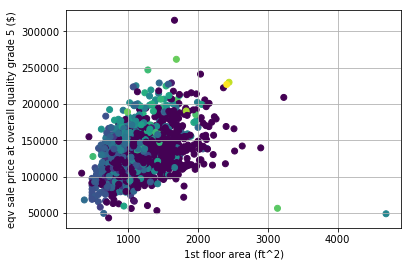

In [362]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset['1stFlrSF'], trainset.NSP_overallq, c = trainset['2ndFlrSF'])
plt.xlabel('1st floor area (ft^2)')
plt.ylabel('eqv sale price at overall quality grade 5 ($)')
plt.grid()
plt.show()

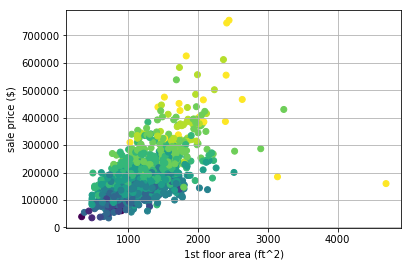

In [370]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset['1stFlrSF'], trainset.SalePrice, c = trainset.OverallQual)
plt.xlabel('1st floor area (ft^2)')
plt.ylabel('sale price ($)')
plt.grid()
plt.show()

The first floor size turns out to have a very higher correlation coefficient with Sale Price. The figure above still suggests overall quality could explain majority of the price variance at a given 1st floor area. We can normalize this feature with a remapped OverallQual. The function $oqmap(OverallQual)$ was derived above in analysis of OverallQual.

In [377]:
trainset = trainset.assign(NSP_logquality = trainset.SalePrice / np.log(trainset.OverallQual))

In [380]:
trainset[['LotArea','1stFlrSF', '2ndFlrSF', 'LowQualFinSF','SalePrice','NSP_overallq', 'NSP_logquality']].corr()

,LotArea,1stFlrSF,2ndFlrSF,LowQualFinSF,SalePrice,NSP_overallq,NSP_logquality
LotArea,1.000000,0.299475,0.050986,0.004779,0.263843,0.351191,0.308962
1stFlrSF,0.299475,1.000000,-0.202646,-0.014241,0.605852,0.361309,0.602292
2ndFlrSF,0.050986,-0.202646,1.000000,0.063353,0.319334,0.176698,0.300616
LowQualFinSF,0.004779,-0.014241,0.063353,1.000000,-0.025606,-0.019981,-0.023511
SalePrice,0.263843,0.605852,0.319334,-0.025606,1.000000,0.520401,0.972081
NSP_overallq,0.351191,0.361309,0.176698,-0.019981,0.520401,1.000000,0.694276
NSP_logquality,0.308962,0.602292,0.300616,-0.023511,0.972081,0.694276,1.000000


It seems that 1st floor area combined with overall quality provides a very good correlation to sale price than lot area with overall quality. Other discrete features are still useful in separating sub trends like MSSubClass. The table above also shows that LowQualFinSF doesn't contribute much into the sale price while 2ndFlrSF does. We add both 1stFlrSF and 2ndFlrSF as features to consider. Furthermore, we may need to consider engineer a feature $1stFlrSF*\log(OverallQual)$ and feature $\log(LotArea)*oqmap(OverallQual)$ as additional continous features.

In [381]:
feats_cont.append(['1stFlrSF','2ndFlrSF'])

In [401]:
trainset = trainset.assign(FFSF_Q = trainset['1stFlrSF'] * trainset.OverallQual.map(oqmap))
trainset = trainset.assign(LotArea_Q = np.log(trainset.LotArea) * trainset.OverallQual.map(oqmap))

In [406]:
feats_cont = ['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'TotalBsmtSF',
 '1stFlrSF', '2ndFlrSF',
 'FFSF_Q', 'LotArea_Q']

In [407]:
trainset[['FFSF_Q', 'LotArea_Q', 'SalePrice']].corr()

,FFSF_Q,LotArea_Q,SalePrice
FFSF_Q,1.000000,0.885672,0.793815
LotArea_Q,0.885672,1.000000,0.851368
SalePrice,0.793815,0.851368,1.000000


In [449]:
def lrCost(theta, X, y):
    """linear regression cost function """
    m = X.shape[0]
    return np.dot((np.dot(X, theta) - y).T, np.dot(X, theta) - y) / 2.0 / m

def lrGradient(theta, X, y):
    """ linear regression gradient """
    return np.dot(X.T, np.dot(X, theta) - y) / X.shape[0]

theta0 = [10.0, 10000.0]
X = np.concatenate((np.ones(shape = (trainset.shape[0], 1)), trainset.LotArea_Q.values.reshape(trainset.shape[0], 1)), axis = 1)
w = scop.fmin_l_bfgs_b(lrCost, theta0, lrGradient, (X, trainset.SalePrice.values))
theta = w[0]
w

(array([  5437.54701931,  14156.73808774]),
 867726955.83152723,
 {'funcalls': 15,
  'grad': array([  4.24559266e-05,   6.00659046e-04]),
  'nit': 5,
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'warnflag': 0})

In [450]:
theta

array([  5437.54701931,  14156.73808774])

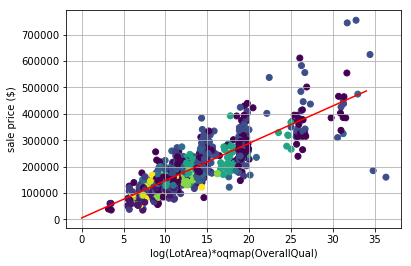

In [451]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea_Q, trainset.SalePrice, c = trainset.MSSubClass)
ax.plot(np.arange(0, 35), np.arange(0, 35)*theta[1] + theta[0], '-r')
plt.xlabel('log(LotArea)*oqmap(OverallQual)')
plt.ylabel('sale price ($)')
plt.grid()
plt.show()

In [453]:
""" first we exclude the far outliers """
FFSFQ_trimset = trainset[trainset.FFSF_Q < 10000]
X = np.concatenate((np.ones(shape = (FFSFQ_trimset.shape[0], 1)), FFSFQ_trimset.FFSF_Q.values.reshape(FFSFQ_trimset.shape[0], 1)), axis = 1)
w = scop.fmin_l_bfgs_b(lrCost, theta0, lrGradient, (X, FFSFQ_trimset.SalePrice.values))
theta = w[0]
w

(array([  7.82998860e+04,   6.18730336e+01]),
 857554135.177688,
 {'funcalls': 21,
  'grad': array([ -1.57577879e-09,  -3.75505733e-06]),
  'nit': 5,
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

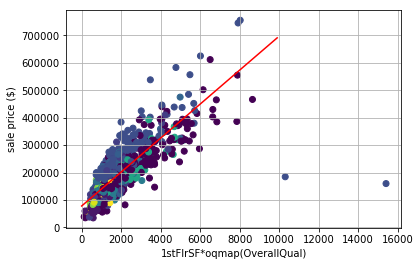

In [455]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.FFSF_Q, trainset.SalePrice, c = trainset.MSSubClass)
ax.plot(np.arange(0, 10000, 100), np.arange(0, 10000, 100)*theta[1] + theta[0], '-r')
plt.xlabel('1stFlrSF*oqmap(OverallQual)')
plt.ylabel('sale price ($)')
plt.grid()
plt.show()

In [413]:
trainset[['FFSF_Q', 'LotArea_Q', '1stFlrSF','GrLivArea','SalePrice']].corr()

,FFSF_Q,LotArea_Q,1stFlrSF,GrLivArea,SalePrice
FFSF_Q,1.000000,0.885672,0.830897,0.636052,0.793815
LotArea_Q,0.885672,1.000000,0.565636,0.633007,0.851368
1stFlrSF,0.830897,0.565636,1.000000,0.566024,0.605852
GrLivArea,0.636052,0.633007,0.566024,1.000000,0.708624
SalePrice,0.793815,0.851368,0.605852,0.708624,1.000000


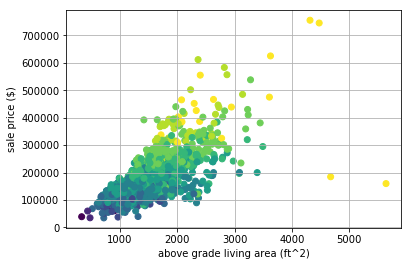

In [412]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.GrLivArea, trainset.SalePrice, c = trainset.OverallQual)
plt.xlabel('above grade living area (ft^2)')
plt.ylabel('sale price ($)')
plt.grid()
plt.show()

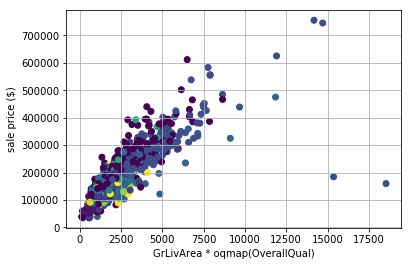

In [414]:
trainset = trainset.assign(GLA_Q = trainset.GrLivArea * trainset.OverallQual.map(oqmap))
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.GLA_Q, trainset.SalePrice, c = trainset.MSSubClass)
plt.xlabel('GrLivArea * oqmap(OverallQual)')
plt.ylabel('sale price ($)')
plt.grid()
plt.show()

We perform similar treatmeant to GrLivArea and add the engineered feature into the list.

In [415]:
feats_cont.append('GLA_Q')

In [416]:
trainset[['BsmtFullBath','SalePrice']].corr()

,BsmtFullBath,SalePrice
BsmtFullBath,1.000000,0.227122
SalePrice,0.227122,1.000000


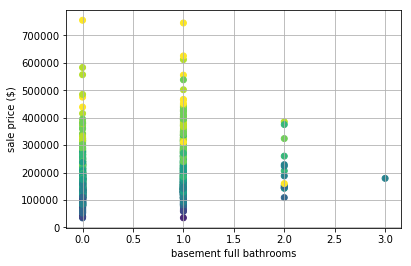

In [417]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.BsmtFullBath, trainset.SalePrice, c = trainset.OverallQual)
plt.xlabel('basement full bathrooms')
plt.ylabel('sale price ($)')
plt.grid()
plt.show()

In [459]:
trainset.groupby('BsmtFullBath')[['SalePrice', 'FFSF_Q']].agg(aggvals)

SalePrice                     FFSF_Q                   
                       std count    mean          std count         mean
BsmtFullBath                                                            
0             68137.819610   856  165521   910.398324   856  1477.712318
1             88895.866415   588  202522  1322.854111   588  1930.061267
2             87308.196346    15  213063  3645.711212    15  2880.403601
3                      NaN     1  179000          NaN     1  1200.000000

The effect of basement full bath count is represented by FFSF_Q already, therefore we leave this feature out.